In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/zipped'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/train_masks.csv')]

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'
PATH/TRAIN_DN

PosixPath('data/carvana/train')

In [9]:
PATH

PosixPath('data/carvana')

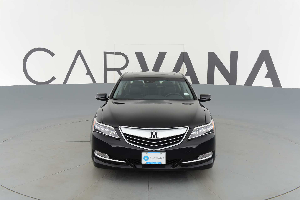

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/3b45f83ba3fa_12_mask.gif'),
 PosixPath('data/carvana/train_masks/78f63d808555_07_mask.gif'),
 PosixPath('data/carvana/train_masks/2ea62c1beee7_03_mask.gif'),
 PosixPath('data/carvana/train_masks/2267f4aa0d2c_05_mask.gif'),
 PosixPath('data/carvana/train_masks/bf9a32258ef4_03_mask.gif')]

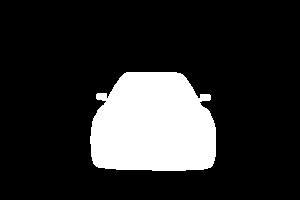

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

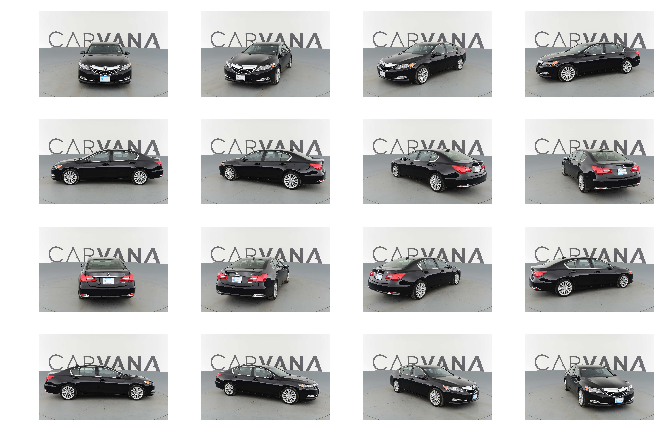

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [15]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [16]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [17]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [18]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [19]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [20]:
(PATH/'train-128').mkdir(exist_ok=True)

In [21]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)
    
files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [23]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [24]:
??open_image

In [25]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

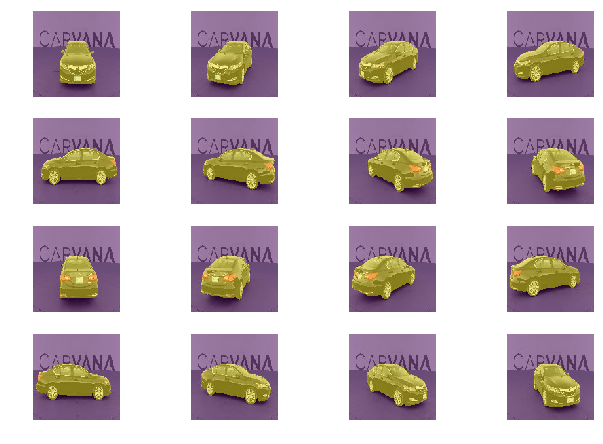

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [27]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [28]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [29]:
len(x_names)//16//5*16

1008

In [30]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [31]:
val_x

array([PosixPath('train-128/00087a6bd4dc_01.jpg'), PosixPath('train-128/00087a6bd4dc_02.jpg'),
       PosixPath('train-128/00087a6bd4dc_03.jpg'), ..., PosixPath('train-128/31186febd775_14.jpg'),
       PosixPath('train-128/31186febd775_15.jpg'), PosixPath('train-128/31186febd775_16.jpg')], dtype=object)

In [32]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [33]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [34]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

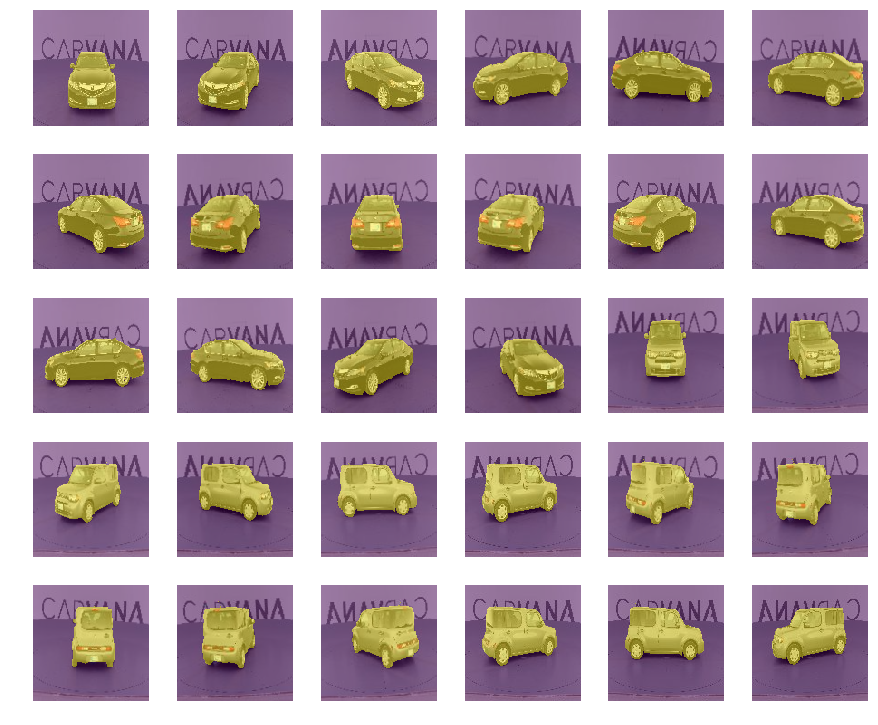

In [35]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [36]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [37]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [38]:
flatten_channel = Lambda(lambda x: x[:,0])

In [39]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [40]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

 86%|████████▌ | 55/64 [00:23<00:03,  2.34it/s, loss=2.36] 

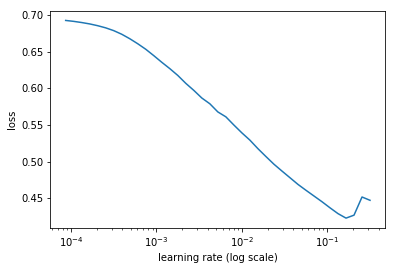

In [41]:
learn.lr_find()
learn.sched.plot()

In [42]:
lr=4e-2

In [43]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.177995   0.131166   0.944779  
    1      0.126658   0.117369   0.953203                  
    2      0.104279   0.101114   0.956327                  
    3      0.092618   0.095525   0.955507                   
    4      0.084347   0.08872    0.958613                   


[array([0.08872]), 0.9586132585056244]

In [44]:
learn.save('tmp')

In [45]:
learn.load('tmp')

In [46]:
py,ay = learn.predict_with_targs()

In [47]:
ay.shape

(1008, 128, 128)

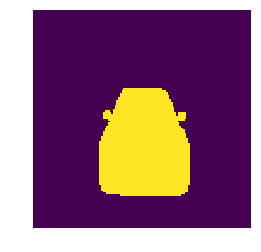

In [48]:
show_img(ay[0]);

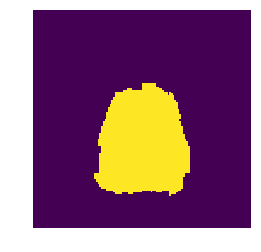

In [49]:
show_img(py[0]>0);

In [50]:
learn.unfreeze()

In [51]:
learn.bn_freeze(True)

In [52]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.078367   0.0559     0.976858  
    1      0.052961   0.045073   0.978214                   
    2      0.041866   0.038815   0.985076                   
    3      0.348526   0.282863   0.876767                   
    4      0.273397   0.219613   0.895628                  
    5      0.265403   0.225175   0.894744                  
    6      0.188383   0.105784   0.957105                  
    7      0.113761   0.073799   0.967167                  
    8      0.077445   0.063178   0.974741                   
    9      0.060707   0.052671   0.976194                   
    10     0.052816   0.048443   0.978165                   


In [87]:
learn.save('0')

In [88]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

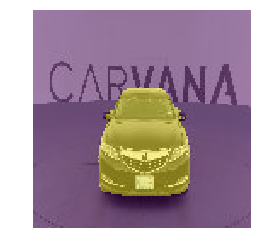

In [89]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

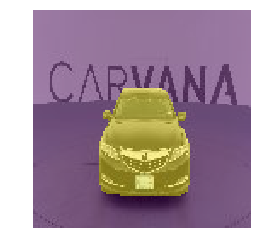

In [90]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 512x512

In [19]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 16

In [20]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [21]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [22]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [60]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

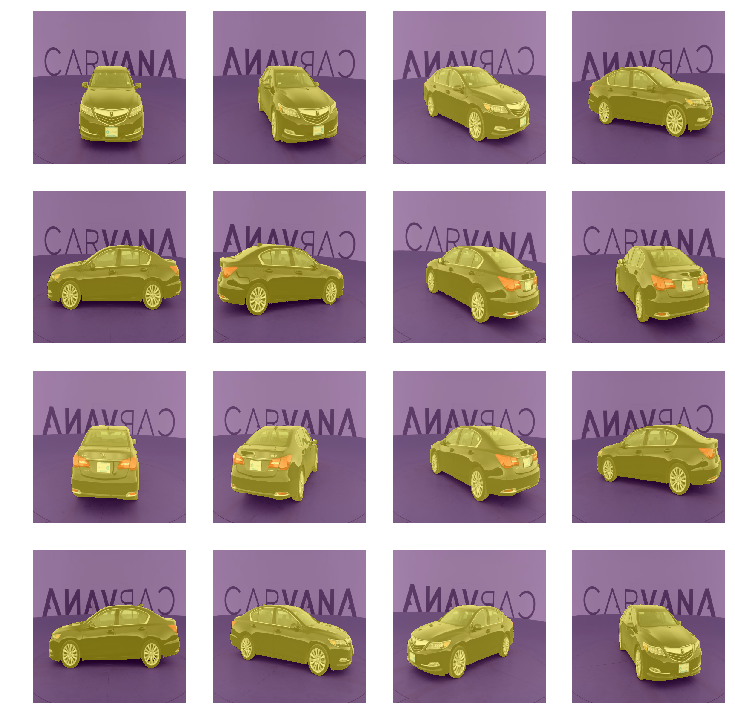

In [61]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [101]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [102]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [103]:
learn.load('0')

A Jupyter Widget

 85%|████████▌ | 218/255 [02:12<00:22,  1.64it/s, loss=8.91] 

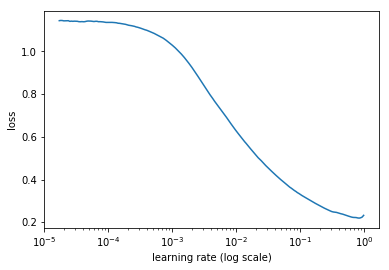

In [21]:
learn.lr_find()
learn.sched.plot()

In [104]:
lr=4e-2

In [105]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                     
    0      0.02178    0.020653   0.991708  
    1      0.017927   0.020653   0.990241                     
    2      0.015958   0.016115   0.993394                     
    3      0.015172   0.015143   0.993696                     
    4      0.014315   0.014679   0.99388                      



[0.014679321, 0.99388032489352751]

In [106]:
learn.save('tmp')

In [120]:
learn.load('tmp')

In [75]:
learn.unfreeze()
learn.bn_freeze(True)

In [76]:
lrs = np.array([lr/100,lr/10,lr])/4

In [77]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                     
    0      0.038687   0.018685   0.992782  
    1      0.024906   0.014355   0.994933                     
    2      0.025055   0.014737   0.995526                     
    3      0.024155   0.014083   0.995708                     
    4      0.013446   0.010564   0.996166                     
    5      0.01607    0.010555   0.996096                     
    6      0.019197   0.010883   0.99621                      
    7      0.016157   0.00998    0.996393                     



[0.0099797687, 0.99639255659920833]

In [78]:
learn.save('512')

In [79]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

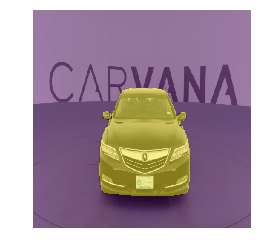

In [80]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

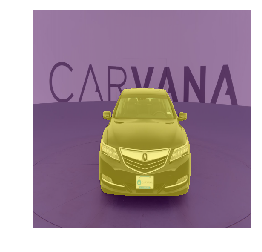

In [81]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 1024x1024

In [23]:
sz = 1024
bs = 4

In [24]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [25]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

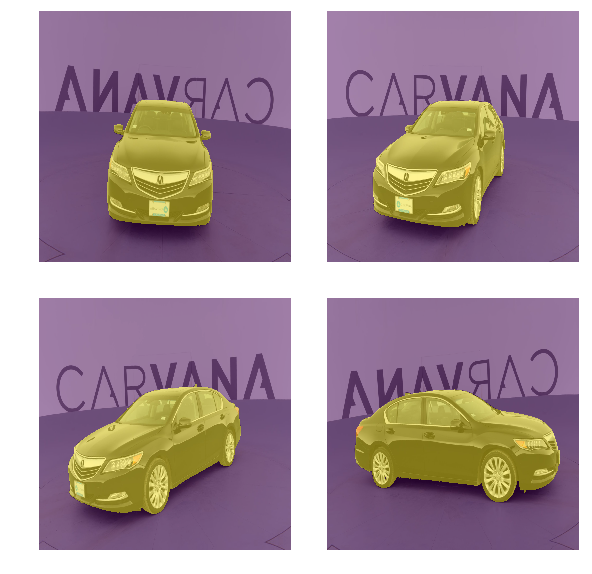

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i,ax in enumerate(axes.flat):
    show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [27]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel,
)

In [28]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [29]:
learn.load('512')

A Jupyter Widget

 85%|████████▌ | 218/255 [02:12<00:22,  1.64it/s, loss=8.91] 

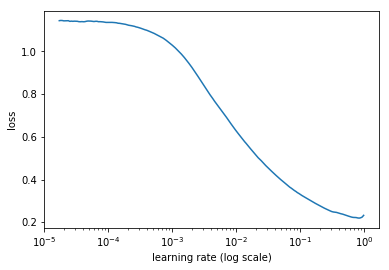

In [21]:
learn.lr_find()
learn.sched.plot()

In [30]:
lr=4e-2

In [31]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                       
    0      0.01066    0.011119   0.996227  
    1      0.009357   0.009696   0.996553                        



[0.0096957013, 0.99655332546385511]

In [32]:
learn.save('tmp')

In [97]:
learn.load('tmp')

In [33]:
learn.unfreeze()
learn.bn_freeze(True)

In [34]:
lrs = np.array([lr/100,lr/10,lr])/8

In [102]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss   mask_acc                       
    0      0.015565   0.007449   0.997661  
    1      0.01979    0.008376   0.997542                       
    2      0.014874   0.007826   0.997736                       
    3      0.016104   0.007854   0.997347                       
    4      0.023386   0.009745   0.997218                       
    5      0.018972   0.008453   0.997588                       
    6      0.013184   0.007612   0.997588                       
    7      0.010686   0.006775   0.997688                       
    8      0.0293     0.015299   0.995782                       
    9      0.018713   0.00763    0.997638                       
    10     0.015432   0.006575   0.9978                         
    11     0.110205   0.060062   0.979043                      
    12     0.014374   0.007753   0.997451                       
    13     0.022286   0.010282   0.997587                       
    14     0.015645   0.00739    0.997776      

[0.0056782686, 0.99817223208291195]

In [103]:
learn.save('1024')

In [104]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

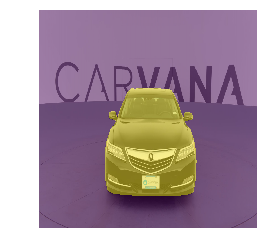

In [105]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

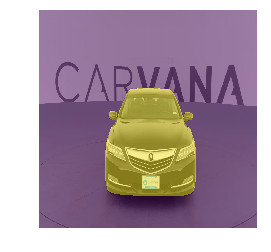

In [106]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

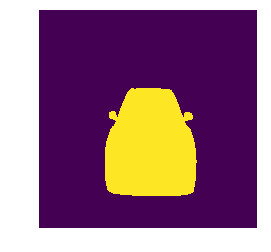

In [107]:
show_img(py[0][0]>0);

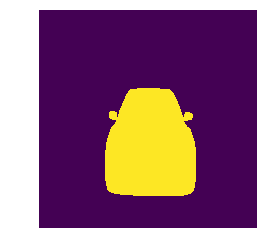

In [108]:
show_img(y[0,...,-1]);

## Fin